## Load the data from the files. 

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
only_letters= r'[^A-Za-z0-9\s]+'

def text_preprocess(sent):
    sent=sent.lower().strip()
    sent=re.sub(only_letters,'',sent)
    sent=re.sub("\s\s+" , " ", sent)
    return sent
    

data_dir='topicclass/'
train_file='topicclass_train.txt'
val_file='topicclass_valid.txt'
test_file='topicclass_test.txt'

def create_data(file_name):
    fp= open(file_name)
    data={'Sentence':[], 'Label':[]}
    for line in fp:
        try:
            line=line.strip().split('|||')
            sent= text_preprocess(line[1]).strip()
            label=line[0].strip()
            data['Sentence'].append(sent)
            data['Label'].append(label)
        except Exception as e:
            print(e)
    
    df= pd.DataFrame(data)
    return df

train_df= create_data(data_dir+train_file)
val_df= create_data(data_dir+val_file)

Total number of training sentences =  253909
Total number of validation sentences =  643


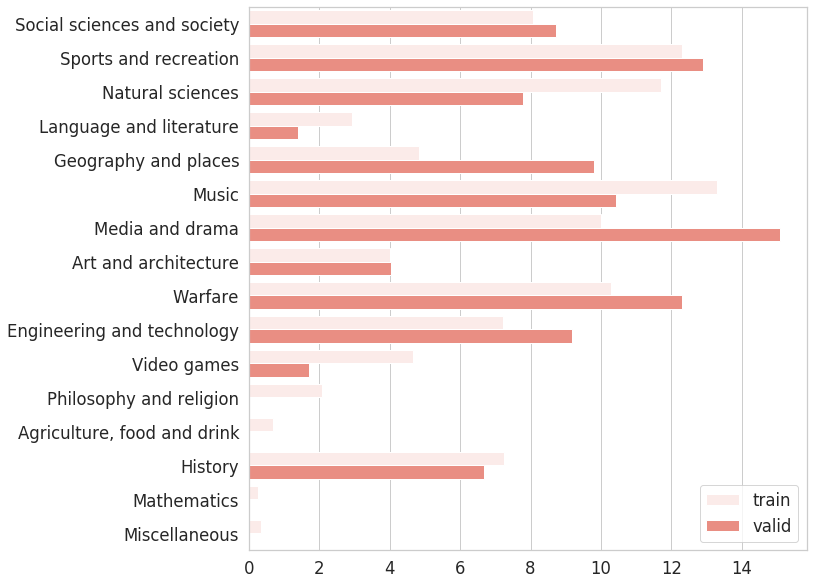

In [2]:
print("Total number of training sentences = ", len(train_df))
print("Total number of validation sentences = ",len(val_df))

# Simple function to create distributions of data over diff features
def create_dists(df,label):
    label_dict={}
    labels=list(df[label])
    count=len(df[label])
    for elem in labels:
        if elem not in label_dict:
            label_dict[elem]=0
        label_dict[elem]+=1    
        
    for elem in label_dict:
        label_dict[elem]=100*label_dict[elem]/count
    return label_dict

train_labels= create_dists(train_df,'Label')
val_labels= create_dists(val_df,'Label')

label_df={}
label_df['Label']=[]
label_df['Type']=[]
label_df['Percentage']=[]

for elem in train_labels:
    label_df['Label'].append(elem)
    label_df['Percentage'].append(train_labels[elem])
    label_df['Type'].append('train')
    if elem not in val_labels:
        label_df['Label'].append(elem)
        label_df['Percentage'].append(0)
        label_df['Type'].append('valid')

for elem in val_labels:
    label_df['Label'].append(elem)
    label_df['Percentage'].append(val_labels[elem])
    label_df['Type'].append('valid')
    if elem not in train_labels:
        label_df['Label'].append(elem)
        label_df['Percentage'].append(0)
        label_df['Type'].append('train')

sns.set(font_scale=1.5) 
plt.figure(figsize=(10,10))
sns.set_style('whitegrid')
sns.barplot(x='Percentage',y='Label',hue='Type', data=label_df,color="salmon")

In [3]:
word_to_idx={}
label_to_idx={}
char_to_idx={}
char_to_idx['<PAD>']=0
word_to_idx['unk']=0
word_to_idx['<PAD>']=1

char_count= len(char_to_idx)
word_count=len(word_to_idx)

train_sents= list(train_df['Sentence'])
for sent in train_sents:
    words= sent.split()
    for word in words:
        if word not in word_to_idx:
            word_to_idx[word]=word_count
            word_count+=1

for word in word_to_idx:
    if word=='<PAD>':
        continue
    for char in word:
        if char not in char_to_idx:
            char_to_idx[char]=char_count
            char_count+=1
            
print('Character vocabulary size = ', len(char_to_idx))
print("Vocabulary size = ", len(word_to_idx))

max_char_len= max([len(w) for w in word_to_idx])

labels= set(train_df['Label'])
for label in labels:
    label_to_idx[label]=len(label_to_idx)
print("Number of labels =", len(label_to_idx))
print("Maximum length of word = ", max_char_len)

Character vocabulary size =  37
Vocabulary size =  114768
Number of labels = 16
Maximum length of word =  50


In [4]:
def create_train_val_vectors():
    train=[]
    val=[]
    for index, row in train_df.iterrows():
        chars=[]
        words=[]
        words.extend([word_to_idx[word] if word in word_to_idx else word_to_idx['unk'] for word in row['Sentence'].split()])
        for word in row['Sentence'].split():
            chars.append([char_to_idx[word[i]] for i in range(min(len(word), max_char_len))]
                         +[char_to_idx['<PAD>'] for i in range(max_char_len-len(word))])
            
        if row['Label'] in label_to_idx:
            label=label_to_idx[row['Label']]
        else:
            label=label_to_idx['unk']
        if len(words)!= len(chars):
            print(len(words), len(chars))     
            
        train.append((chars, words,label))
           
    for index, row in val_df.iterrows():
        words=[]
        chars=[]
        words.extend([word_to_idx[word] if word in word_to_idx else word_to_idx['unk'] for word in row['Sentence'].split()])
        for word in row['Sentence'].split():
              chars.append([char_to_idx[word[i]] for i in range(min(len(word), max_char_len))]
                         +[char_to_idx['<PAD>'] for i in range(max_char_len-len(word))])
#             chars.append([char_to_idx[char] for char in word]+[char_to_idx['<PAD>'] for i in range(max_char_len-len(word))])
        if row['Label'] in label_to_idx:
            label=label_to_idx[row['Label']]
        else:
            label=label_to_idx['unk'] 
        if len(words)!= len(chars):
            print(len(words), len(chars))        
        val.append((chars,words,label))
    
    return train, val    

train_arr, val_arr =create_train_val_vectors()

for elem in train_arr:
    if len(elem[0])!=len(elem[1]):
        print(len(elem[0]), len(elem[1]))

In [20]:
def create_glove_vectors(glove_data_file='/data/glove_vector/glove.6B.300d.txt'):
    glove_dict={}
    data_file= open(glove_data_file)
    for line in data_file:
        line=line.strip().split()
        glove_dict[line[0]]=np.float32(np.array([float(i) for i in line[1:]]))
    return glove_dict
glove_dict= create_glove_vectors()

def create_weight_matrix(word_to_idx, glove_dict, embed_dim=300):
    id_to_word2vec_vec= np.zeros((len(word_to_idx), embed_dim))
    id_to_glove_vec=np.zeros((len(word_to_idx), embed_dim ))
    id_to_fasttext_vec=np.zeros((len(word_to_idx), embed_dim))
    for w in word_to_idx:
        if w=='<PAD>':
            continue
        if w in glove_dict:
            id_to_glove_vec[word_to_idx[w]]= glove_dict[w]
        else:
            id_to_glove_vec[word_to_idx[w]]= glove_dict['unk']
    return id_to_glove_vec

id_to_glove_vec = create_weight_matrix(word_to_idx, glove_dict, 300)

In [5]:
VOCAB_SIZE= len(word_to_idx)
CHAR_VOCAB_SIZE = len(char_to_idx)
LABEL_SIZE= len(label_to_idx)
EMB_SIZE= 300
WIN_SIZE=3
FILTER_MAP= 100
BATCH_SIZE= 256
# BATCH_SIZE= 2048
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    torch.manual_seed(11747)    
    
longtype = torch.LongTensor
floattype= torch.FloatTensor
use_cuda = torch.cuda.is_available()
import random
import time 
from torch.utils.data import DataLoader

batch_cnt=0

def get_batches(batch):
    label = torch.tensor([entry[2] for entry in batch])
    max_len= max([len(entry[1]) for entry in batch]) # maximum number of words 
    text =[entry[1]+ [word_to_idx['<PAD>'] for i in range(max_len-len(entry[1]))] for entry in batch]  
    chars=[]
    for entry in batch:
        char_arr= list(entry[0])
        for i in range(max_len-len(entry[1])):
            char_arr.append([char_to_idx['<PAD>'] for j in range(max_char_len)])
        chars.append(char_arr)
        if len(entry[0])!=len(entry[1]):
            print(len(entry[0]), len(entry[1]))
    
    return chars, text, label

train_data = DataLoader(train_arr, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=get_batches)
valid_data = DataLoader(val_arr, batch_size=32, shuffle=True,
                      collate_fn=get_batches)

In [25]:
class KIM_CHAR_CNN(torch.nn.Module):
    def __init__(self, nwords, word_emb_size, nchars, char_emb_size, c2w_emb_size ,char_window_size, 
                 word_window_sizes, char_filter_dim, word_filter_dim, ntags, trainable_flag, 
                 emb_type=None, dropout=0.5):
        
        super(KIM_CHAR_CNN, self).__init__()
        
        if emb_type=='glove':
            self.embedding= nn.Embedding.from_pretrained(torch.FloatTensor(id_to_glove_vec))
        elif emb_type=='fasttext':
            self.embedding= nn.Embedding.from_pretrained(torch.FloatTensor(id_to_fasttext_vec))
        else:
            self.embedding= nn.Embedding(nwords, word_emb_size, padding_idx=word_to_idx['<PAD>'])
            nn.init.uniform_(self.embedding.weight, -0.25,0.25)

        self.embedding.weight.requires_grad= trainable_flag
        
        self.c2w_embedding= self.char_CNN(nchars, char_emb_size, c2w_emb_size, char_filter_dim, 
                                          char_window_size, trainable_flag)
        # applying 1 layer convolution 
        
        self.convs= nn.ModuleList([nn.Conv1d(in_channels= word_emb_size, #+ c2w_emb_size, 
                                             out_channels=word_filter_dim,
                                             kernel_size= window_size) for window_size in word_window_sizes])
        
        # self.conv2d= nn.Conv2d(in_channels=emb_size,out_channels=num_filters, kernel_size=window_size)
     
        
        self.relu= nn.ReLU()
        self.dropout= nn.Dropout(dropout)
        self.projection_layer= nn.Linear(in_features=word_filter_dim*len(word_window_sizes), out_features=ntags, bias=True)
        nn.init.xavier_uniform_(self.projection_layer.weight)
    
    def forward(self, words, chars, return_activations=False):
        embeds=self.embedding(words) # BATCH_SIZE * n*_words * dim
        c2w_embeds= self.c2w_embedding(chars)
        embeds= embeds.add(c2w_embeds)
        
#         embeds= torch.cat((embeds, c2w_embeds),2)
#         print(embeds.shape)
        embeds=embeds.permute(0,2,1) # BATCH_SIZE * dim *n_words
        h=[conv(embeds) for conv in self.convs] # [BATCH_SIZE * n_filters*(n_words- window_size +1)] * len(WINDOW_SIZE)
#         print('\n\n Start the operations')
#         print(h[0].shape)
        h=[self.relu(h1) for h1 in h]  
#         print(h[0].shape)
        h=[h1.max(dim=2)[0] for h1 in h]
#         print(h[0].shape)
        h= torch.cat(h,1)
#         print(h.shape)
        h= self.dropout(h)
        out= self.projection_layer(h)
        return out
    
    class char_CNN(torch.nn.Module):
        def __init__(self, nchars, char_emb_size, c2w_emb_size, char_filter_dim, 
                     char_window_size, trainable_flag):
            super().__init__()
            
            self.char_embedding= nn.Embedding(nchars, char_emb_size, padding_idx= char_to_idx['<PAD>'])
            nn.init.uniform_(self.char_embedding.weight, -0.25,0.25)
            self.char_embedding.weight.requires_grad= trainable_flag
            self.conv1d= nn.Conv1d(in_channels=char_emb_size, out_channels=char_filter_dim,
                                   kernel_size=char_window_size)
            self.relu= nn.ReLU()
            self.projection_layer= nn.Linear(in_features = char_filter_dim,
                                             out_features= c2w_emb_size, bias=True)
            
            nn.init.xavier_uniform_(self.projection_layer.weight)


        def forward(self, chars):
            embeds=self.char_embedding(chars) # BATCH_SIZE * n_chars* char_dim
            embeds=embeds.permute(0,1,3,2) # BATCH_SIZE * n_wordds * char_dim *n_chars
            B,W,D,C= embeds.shape
            embeds= embeds.reshape(B*W, D,C) # (BATCH_SIZE *n_words) * char_dim * n_chars
            h= self.conv1d(embeds)  #  (BATCH_SIZE * n_words)*filter_dim *(n_chars- window_size +1)
            h= h.max(dim=2)[0]  # (BATCH_SIZE * n_words)* filter_dim
            h= self.relu(h)
            out= self.projection_layer(h) # (BATCH_SIZE * n_words)* word_embedding
            out= out.reshape(B, W, -1)
            return out

In [26]:
def accuracy(y_preds,y_true):
    count=0
    for i,j in zip(y_preds,y_true):
        if i==j:
            count+=1
    return count/len(y_true)

import sklearn.metrics

def run_model(model):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    if use_cuda:
        longtype = torch.cuda.LongTensor
        floattype= torch.cuda.FloatTensor
        model.cuda()
    best_dev_acc=0
    best_model=None
    best_epoch=0
    dev_f1=0
    
    for ITER in range(10):
        train_loss = 0.0
        train_accs=[]
        val_accs=[]
        train_f1s=[]
        val_f1s=[]
        start = time.time()
        valid_loss=0.0
        valid_correct=0


        for index, (chars, text,labels) in enumerate(train_data):
#             import pdb
#             breakpoint()
            try:
                text= torch.tensor(text).type(longtype)
                chars= torch.tensor(chars).type(longtype)
    #             print(chars)
            except Exception as e:
                import pdb
                breakpoint()
            labels= labels.type(longtype)
#             print(text.shape, chars.shape)
            
            scores=model(text, chars)
            predict=[score.argmax().item() for score in scores]
            accs= sklearn.metrics.accuracy_score(labels, predict)
            f1= sklearn.metrics.f1_score(labels,predict, average='macro')
            train_accs.append(accs)
            train_f1s.append(f1)

            my_loss = criterion(scores, labels)
            train_loss += my_loss.item()
            optimizer.zero_grad()
            my_loss.backward()
            optimizer.step()

        print("iter %r: train loss/sent=%.4f, acc=%.4f, time=%.2fs" % (
            ITER, train_loss / len(train_data), np.mean(train_accs), time.time() - start))

        for index, (chars, text,labels) in enumerate(valid_data):
            text= torch.tensor(text).type(longtype)
            chars= torch.tensor(chars).type(longtype)

            labels= labels.type(longtype)
            scores=model(text,chars)
            predict=[score.argmax().item() for score in scores]
            accs= sklearn.metrics.accuracy_score(labels, predict)
            f1= sklearn.metrics.f1_score(labels,predict, average='macro')            
            val_accs.append(accs)
            val_f1s.append(f1)

        if np.mean(val_accs) > best_dev_acc:
            best_model=model
            best_dev_acc= np.mean(val_accs)
            best_epoch= ITER
            dev_f1= np.mean(val_f1s)

        print("iter %r: test acc=%.4f" % (ITER, np.mean(val_accs)))
    print('Best dev accuracy is ='+ str(round(best_dev_acc,4)) +
          ' at epoch = '+ str(best_epoch)) 
    print('Corresponding dev F1 is ='+ str(round(dev_f1,4)) +
          ' at epoch = '+ str(best_epoch)) 
    
    return best_dev_acc, dev_f1



In [27]:
# def __init__(self, nwords, word_emb_size, nchars, char_emb_size, c2w_emb_size ,char_window_size, 
#                  word_window_sizes, char_filter_dim, word_filter_dim, ntags, trainable_flag, 
#                  emb_type=None, dropout=0.5):

WORD_VOCAB_SIZE= len(word_to_idx)
CHAR_VOCAB_SIZE= len(char_to_idx)
WORD_EMB_SIZE= 300
CHAR_EMB_SIZE=50
C2W_EMB_SIZE= WORD_EMB_SIZE
CHAR_FILTER_MAP=50
WORD_FILTER_MAP=100
CHAR_WINDOW_SIZE=3
WORD_WINDOW_SIZES=[3,4,5]
LABEL_SIZE= len(label_to_idx)
DROPOUT=0

torch.cuda.set_device(2)

for i in range(0,3):
    print('Static word and char embeddings')
    model_rand = KIM_CHAR_CNN(WORD_VOCAB_SIZE, WORD_EMB_SIZE, CHAR_VOCAB_SIZE, CHAR_EMB_SIZE, C2W_EMB_SIZE,
                             CHAR_WINDOW_SIZE, WORD_WINDOW_SIZES, CHAR_FILTER_MAP, WORD_FILTER_MAP, LABEL_SIZE,
                              True, DROPOUT)
    acc,f1= run_model(model_rand)
    print(acc, f1)
    


Static word and char embeddings


/usr0/home/rdutt/anaconda3/envs/persuadee_tactics/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


iter 0: train loss/sent=1.1562, acc=0.6508, time=272.38s
iter 0: test acc=0.7902
iter 1: train loss/sent=0.6212, acc=0.8124, time=275.48s
iter 1: test acc=0.7599
iter 2: train loss/sent=0.4087, acc=0.8760, time=272.80s
iter 2: test acc=0.7426
iter 3: train loss/sent=0.2837, acc=0.9116, time=275.11s
iter 3: test acc=0.7535
iter 4: train loss/sent=0.2054, acc=0.9355, time=271.86s
iter 4: test acc=0.7326
iter 5: train loss/sent=0.1572, acc=0.9506, time=275.54s
iter 5: test acc=0.7183
iter 6: train loss/sent=0.1245, acc=0.9608, time=271.64s
iter 6: test acc=0.7049
iter 7: train loss/sent=0.1012, acc=0.9676, time=274.40s
iter 7: test acc=0.7326
iter 8: train loss/sent=0.0859, acc=0.9725, time=271.30s
iter 8: test acc=0.7192
iter 9: train loss/sent=0.0750, acc=0.9758, time=275.16s
iter 9: test acc=0.7460
Best dev accuracy is =0.7902 at epoch = 0
Corresponding dev F1 is =0.7123 at epoch = 0
0.7901785714285714 0.7122636569105012
Static word and char embeddings
iter 0: train loss/sent=1.1555, a

In [ ]:
WORD_VOCAB_SIZE= len(word_to_idx)
CHAR_VOCAB_SIZE= len(char_to_idx)
WORD_EMB_SIZE= 300
CHAR_EMB_SIZE=50
C2W_EMB_SIZE= WORD_EMB_SIZE
CHAR_FILTER_MAP=50
WORD_FILTER_MAP=100
CHAR_WINDOW_SIZE=3
WORD_WINDOW_SIZES=[3,4,5]
LABEL_SIZE= len(label_to_idx)
DROPOUT=0

torch.cuda.set_device(2)

for i in range(0,3):
    print('Static word and char embeddings')
    model_rand = KIM_CHAR_CNN(WORD_VOCAB_SIZE, WORD_EMB_SIZE, CHAR_VOCAB_SIZE, CHAR_EMB_SIZE, C2W_EMB_SIZE,
                             CHAR_WINDOW_SIZE, WORD_WINDOW_SIZES, CHAR_FILTER_MAP, WORD_FILTER_MAP, LABEL_SIZE,
                              True, DROPOUT)
    acc,f1= run_model(model_rand)
    print(acc, f1)
    


Static word and char embeddings
iter 0: train loss/sent=1.1601, acc=0.6485, time=198.87s
iter 0: test acc=0.8051
iter 1: train loss/sent=0.6210, acc=0.8130, time=204.23s
iter 1: test acc=0.7753
iter 2: train loss/sent=0.4072, acc=0.8754, time=198.97s
iter 2: test acc=0.7331
iter 3: train loss/sent=0.2820, acc=0.9132, time=205.14s
iter 3: test acc=0.7475
iter 4: train loss/sent=0.2047, acc=0.9359, time=197.91s
iter 4: test acc=0.7287
iter 5: train loss/sent=0.1562, acc=0.9507, time=203.36s
iter 5: test acc=0.7168
iter 6: train loss/sent=0.1245, acc=0.9602, time=193.10s
iter 6: test acc=0.7431
iter 7: train loss/sent=0.1011, acc=0.9679, time=194.47s
iter 7: test acc=0.7664
iter 8: train loss/sent=0.0858, acc=0.9730, time=193.01s
iter 8: test acc=0.7684
iter 9: train loss/sent=0.0756, acc=0.9760, time=193.43s
iter 9: test acc=0.7440
Best dev accuracy is =0.8051 at epoch = 0
Corresponding dev F1 is =0.7183 at epoch = 0
0.8050595238095238 0.7182990540757284
Static word and char embeddings
i

In [9]:
# def accuracy(y_preds,y_true):
#     count=0
#     for i,j in zip(y_preds,y_true):
#         if i==j:
#             count+=1
#     return count/len(y_true)

# def run_model(model):
#     criterion = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     if use_cuda:
#         longtype = torch.cuda.LongTensor
#         floattype= torch.cuda.FloatTensor
#         model.cuda()
#     best_dev_acc=0
#     best_model=None
#     best_epoch=0

#     for ITER in range(10):
#     #     Perform training
#         random.shuffle(train)
#         train_loss = 0.0
#         train_accs=[]
#         val_accs=[]
#         start = time.time()
#         valid_loss=0.0
#         valid_correct=0


#         for index, (chars, text,labels) in enumerate(train_data):
# #             import pdb
# #             breakpoint()
#             try:
#                 text= torch.tensor(text).type(longtype)
#                 chars= torch.tensor(chars).type(longtype)
#     #             print(chars)
#             except Exception as e:
#                 import pdb
#                 breakpoint()
#             labels= labels.type(longtype)
#             scores=model(text, chars)
#             predict=[score.argmax().item() for score in scores]
#             train_accs.append(accuracy(predict,labels))

#             my_loss = criterion(scores, labels)
#             train_loss += my_loss.item()
#             optimizer.zero_grad()
#             my_loss.backward()
#             optimizer.step()

#         print("iter %r: train loss/sent=%.4f, acc=%.4f, time=%.2fs" % (
#             ITER, train_loss / len(train), np.mean(train_accs), time.time() - start))

#         for index, (chars, text,labels) in enumerate(valid_data):
#             text= torch.tensor(text).type(longtype)
#             chars= torch.tensor(chars).type(longtype)

#             labels= labels.type(longtype)
#             scores=model(text,chars)
#             predict=[score.argmax().item() for score in scores]
#             val_accs.append(accuracy(predict, labels))

#         if np.mean(val_accs) > best_dev_acc:
#             best_model=model
#             best_dev_acc= np.mean(val_accs)
#             best_epoch= ITER

#         print("iter %r: test acc=%.4f" % (ITER, np.mean(val_accs)))
#     print('Best dev accuracy is ='+ str(round(best_dev_acc,4)) + ' at epoch = '+ str(best_epoch)) 


In [41]:
class char_NN(torch.nn.Module):
    def __init__(self, nchars, char_emb_size, word_emb_size, filter_dim, window_size, trainable_flag,dropout):
        super(char_NN, self).__init__()
        self.char_embedding= nn.Embedding(nchars, char_emb_size, padding_idx= char_to_idx['<PAD>'])
        nn.init.uniform_(self.char_embedding.weight, -0.25,0.25)
        self.char_embedding.weight.requires_grad= trainable_flag
        self.conv1d= nn.Conv1d(in_channels=char_emb_size, out_channels=filter_dim ,kernel_size=window_size)
        self.relu= nn.ReLU()
        self.dropout= nn.Dropout(dropout)
        self.projection_layer= nn.Linear(in_features=filter_dim,
                                         out_features=word_emb_size, bias=True)
        nn.init.xavier_uniform_(self.projection_layer.weight)
        
        
    def forward(self, chars):
        embeds=self.char_embedding(chars) # BATCH_SIZE * n_chars* char_dim
        embeds=embeds.permute(0,1,3,2) # BATCH_SIZE * n_wordds * char_dim *n_chars
        B,W,D,C= embeds.shape
        embeds= embeds.reshape(B*W, D,C) # (BATCH_SIZE *n_words) * char_dim * n_chars
        print(embeds)
        h= self.conv1d(embeds)  #  (BATCH_SIZE * n_words)*filter_dim *(n_chars- window_size +1)
        h= h.max(dim=2)[0]  # (BATCH_SIZE * n_words)* filter_dim
        h= self.relu(h)
        out= self.projection_layer(h) # (BATCH_SIZE * n_words)* word_embedding
        out= out.reshape(B, W, -1)
        return out

model=char_NN(5,2,7,3,3,True,0)
model(torch.LongTensor([[[1,2,0,0],[2,2,0,0],[1,1,2,3]],[[1,2,0,0],[2,2,0,0],[1,1,2,3]]]))


tensor([[[-0.2180, -0.0151,  0.1562,  0.1562],
         [ 0.0264,  0.0433,  0.1343,  0.1343]],

        [[-0.0151, -0.0151,  0.1562,  0.1562],
         [ 0.0433,  0.0433,  0.1343,  0.1343]],

        [[-0.2180, -0.2180, -0.0151,  0.0950],
         [ 0.0264,  0.0264,  0.0433, -0.0507]],

        [[-0.2180, -0.0151,  0.1562,  0.1562],
         [ 0.0264,  0.0433,  0.1343,  0.1343]],

        [[-0.0151, -0.0151,  0.1562,  0.1562],
         [ 0.0433,  0.0433,  0.1343,  0.1343]],

        [[-0.2180, -0.2180, -0.0151,  0.0950],
         [ 0.0264,  0.0264,  0.0433, -0.0507]]], grad_fn=<AsStridedBackward>)


tensor([[[-0.4993,  0.1358, -0.7929, -0.4450,  0.6062, -0.2575, -0.4996],
         [-0.4986,  0.1245, -0.8142, -0.4416,  0.6293, -0.2434, -0.5023],
         [-0.4193,  0.2051, -0.7911, -0.3116,  0.7642, -0.1595, -0.4574]],

        [[-0.4993,  0.1358, -0.7929, -0.4450,  0.6062, -0.2575, -0.4996],
         [-0.4986,  0.1245, -0.8142, -0.4416,  0.6293, -0.2434, -0.5023],
         [-0.4193,  0.2051, -0.7911, -0.3116,  0.7642, -0.1595, -0.4574]]],
       grad_fn=<AsStridedBackward>)

In [34]:
import pickle
chars= pickle.load(open('a.p','rb'))
print(len(chars))

256


In [28]:
import pickle
import os
import numpy as np
files=os.listdir()
print(files)

for file in sorted(files):
    if file.endswith('.p'):
        try:
            with open(file,'rb') as handle:
                model_dict=pickle.load(handle)
                for elem in model_dict:
                    name= '&'.join(elem.split('_'))
                    acc_mean= str(round(np.mean(model_dict[elem]['acc']),4))
                    acc_std =str(round(np.std(model_dict[elem]['acc']),4))
                    f1_mean = str(round(np.mean(model_dict[elem]['f1']),4))
                    f1_std = str(round(np.std(model_dict[elem]['f1']),4))
                    
                    print(name+'&'+acc_mean+'<>'+acc_std+'&'+f1_mean+'<>'+f1_std+'\\\\')
#                     print( +'&'++'&'+
#                           str(round(np.mean(model_dict[elem]['f1']),4))+'\\\\')
                    
        except Exception as e:
            continue

['.git', 'KIM_CNN_glove_dynamic_0.3.p', 'topicclass', 'CNN_model.py', 'KIM_CNN_glove_dynamic_0.0_128.p', 'Char-CNN-embeddings.ipynb', 'simple_model.py', 'KIM_CNN_glove_dynamic_0.0_32.p', 'KIM_CNN_glove_dynamic_0.4.p', 'model.py', 'run_KIM_models.sh', 'data_process.py', '.ipynb_checkpoints', 'KIM_CNN_glove_dynamic_0.2.p', 'KIM_CNN_glove_dynamic_0.0_64.p', 'Readme.md', 'data_preprocess.ipynb', 'KIM_CNN_glove_dynamic_0.1.p', 'KIM_CNN_glove_dynamic_0.0_16.p', 'model_dict.p', 'models', 'run_models.sh']
KIM&CNN&glove&dynamic&0.0&128&0.8425<>0.0029&0.7565<>0.0042\\
KIM&CNN&glove&dynamic&0.0&16&0.8419<>0.0033&0.7559<>0.0035\\
KIM&CNN&glove&dynamic&0.0&32&0.846<>0.0011&0.7634<>0.0017\\
KIM&CNN&glove&dynamic&0.0&64&0.8416<>0.0015&0.7549<>0.0048\\
KIM&CNN&glove&dynamic&0.1&0.8401<>0.0026&0.7568<>0.0064\\
KIM&CNN&glove&dynamic&0.2&0.8368<>0.005&0.749<>0.0048\\
KIM&CNN&glove&dynamic&0.3&0.8392<>0.0045&0.7523<>0.0091\\
KIM&CNN&glove&dynamic&0.4&0.832<>0.0065&0.7463<>0.0078\\
